<h1><img src='https://sprtsiq.com/img/logo/SprtsIQ_Logo.png' width='15%' style='padding-right: 50px'></img>Time Series Model Exploration</h1>


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from utils import plotting
from tqdm.auto import tqdm, trange
from utils import palette
from celluloid import Camera
from IPython.display import HTML
tqdm.pandas(colour=palette.colors[0], desc='Building dataset')

In [2]:
%load_ext autoreload

In [3]:
RANDOM_STATE = 42

In [4]:
# Reading the data
df = pd.read_excel('data/GameStatsTeamVsOpponentRegPostV2_edited.xlsx', engine='openpyxl')

In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

## Data Cleaning

In [7]:
df = df[df.MoneyLineWinLoss != 'Tie']
df = df[df.SeasonType == 1] # NOTE: WHY, drops ~300
df = df.drop(columns=['GameKey', 'SeasonType'])

In [8]:
if not len(df.dropna()) == len(df):
    print('Null values found in data')
else:
    print('Data clean of null values')

Null values found in data


In [9]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7660 entries, 0 to 7987
Data columns (total 118 columns):
 #    Column                                 Non-Null Count  Dtype         
---   ------                                 --------------  -----         
 0    MoneyLineWinLoss                       7660 non-null   object        
 1    WinLossMargin                          7660 non-null   int64         
 2    SpreadWinLoss                          7660 non-null   object        
 3    SpreadWinLossMargin                    7660 non-null   float64       
 4    OverUnderResult                        7660 non-null   object        
 5    OverUnderMargin                        7660 non-null   float64       
 6    GameStatus                             7660 non-null   object        
 7    Date                                   7660 non-null   datetime64[ns]
 8    Season                                 7660 non-null   int64         
 9    Week                                   7660 non-nu

### PlayingSurface

In [10]:
df['PlayingSurface'].value_counts()

Grass            4028
Artificial       2192
Dome             1206
FieldTurf         116
Natural Grass      16
Name: PlayingSurface, dtype: int64

In [11]:
df[df['PlayingSurface'].isna()]['Stadium'].value_counts()

TCF Bank Stadium     48
Levi's Stadium       48
Tottenham Stadium     4
Cowboys Stadium       2
Name: Stadium, dtype: int64

#### Cowboys Stadium

In [12]:
df[df['Stadium'] == 'Cowboys Stadium']['PlayingSurface']

1642    Artificial
1657    Artificial
1670    Artificial
1674    Artificial
1783    Artificial
           ...    
4108          Dome
4162          Dome
4165          Dome
4226          Dome
4243          Dome
Name: PlayingSurface, Length: 80, dtype: object

In [13]:
df[df['Stadium'] == 'Cowboys Stadium']['PlayingSurface'].value_counts()

Artificial    62
Dome          16
Name: PlayingSurface, dtype: int64

In [14]:
df[(df['Stadium'] == 'Cowboys Stadium') & (df['PlayingSurface'].isna())]['Date']

3417   2012-10-28 16:25:00
3431   2012-10-28 16:25:00
Name: Date, dtype: datetime64[ns]

In [15]:
df[(df['Stadium'] == 'Cowboys Stadium') & (pd.DatetimeIndex(df['Date']).year == 2012)]['PlayingSurface']

3276    Artificial
3297    Artificial
3305    Artificial
3308    Artificial
3417           NaN
3431           NaN
3503    Artificial
3504    Artificial
3532    Artificial
3555    Artificial
3564    Artificial
3581    Artificial
3628    Artificial
3646    Artificial
3660    Artificial
3674    Artificial
Name: PlayingSurface, dtype: object

In [16]:
df['PlayingSurface'] = df.apply(
    lambda x: 'Artificial' if (
        (x['Stadium'] == 'Cowboys Stadium') and pd.isna(x['PlayingSurface'])
 ) else x['PlayingSurface'],
 axis=1
)

#### Tottenham Stadium

In [17]:
np.all(df[df['Stadium'] == 'Tottenham Stadium']['PlayingSurface'].isna())

True

In [18]:
# googled it: https://www.wikiwand.com/en/Tottenham_Hotspur_Stadium
df['PlayingSurface'] = df.apply(
    lambda x: 'FieldTurf' if (
        (x['Stadium'] == 'Tottenham Stadium') and pd.isna(x['PlayingSurface'])
 ) else x['PlayingSurface'],
 axis=1
)

#### Levi's Stadium

In [19]:
np.all(df[df['Stadium'] == "Levi's Stadium"]['PlayingSurface'].isna())

False

In [20]:
df[df['Stadium'] == "Levi's Stadium"]['PlayingSurface'].value_counts()

Grass    58
Name: PlayingSurface, dtype: int64

In [21]:
# googled it: https://www.wikiwand.com/en/Levi%27s_Stadium
df['PlayingSurface'] = df.apply(
    lambda x: 'Grass' if (
        (x['Stadium'] == "Levi's Stadium") and pd.isna(x['PlayingSurface'])
 ) else x['PlayingSurface'],
 axis=1
)

#### TCF Bank Stadium

In [22]:
np.all(df[df['Stadium'] == 'TCF Bank Stadium']['PlayingSurface'].isna())

False

In [23]:
df[df['Stadium'] == 'TCF Bank Stadium']['PlayingSurface'].value_counts()

Artificial    12
FieldTurf      2
Name: PlayingSurface, dtype: int64

In [24]:
df[(df['Stadium'] == 'TCF Bank Stadium') & (df['PlayingSurface'] == 'FieldTurf')]['Date']

2557   2010-12-20
2572   2010-12-20
Name: Date, dtype: datetime64[ns]

In [25]:
df[(df['Stadium'] == 'TCF Bank Stadium') & (df['PlayingSurface'] == 'Artificial')]['Date']

5893   2017-09-11 19:10:00
5895   2017-09-11 19:10:00
5956   2017-09-24 13:00:00
5965   2017-09-24 13:00:00
5978   2017-10-01 13:00:00
5988   2017-10-01 13:00:00
6036   2017-10-15 13:00:00
6045   2017-10-15 13:00:00
6058   2017-10-22 13:00:00
6074   2017-10-22 13:00:00
6181   2017-11-19 13:00:00
6184   2017-11-19 13:00:00
Name: Date, dtype: datetime64[ns]

In [26]:
df[(df['Stadium'] == 'TCF Bank Stadium') & (df['PlayingSurface'].isna())]['Date'].min()

Timestamp('2014-09-14 13:00:00')

In [27]:
df[(df['Stadium'] == 'TCF Bank Stadium') & (df['PlayingSurface'].isna())]['Date'].max()

Timestamp('2017-01-01 13:00:00')

In [28]:
# googled it: https://www.thedailygopher.com/2016/5/4/11576228/tcf-bank-stadium-field-turf-minnesota-football-vikings
df['PlayingSurface'] = df.apply(
    lambda x: 'FieldTurf' if (
        (x['Stadium'] == 'TCF Bank Stadium') and pd.isna(x['PlayingSurface'])
 ) else x['PlayingSurface'],
 axis=1
)

### Temperature, Humidity, & WindSpeed  

In [29]:
# TODO: fill these values
df = df.dropna(subset=['Temperature', 'Humidity', 'WindSpeed'])

In [30]:
if not len(df.dropna()) == len(df):
    print('Null values found in data')
else:
    print('Data clean of null values')

Data clean of null values


## Create a Windowed Dataset

In [31]:
df.select_dtypes(include='object').columns

Index(['MoneyLineWinLoss', 'SpreadWinLoss', 'OverUnderResult', 'GameStatus',
       'Team', 'Opponent', 'HomeOrAway', 'Stadium', 'PlayingSurface',
       'FavoriteUnderdog'],
      dtype='object')

In [32]:
categorical = ['MoneyLineWinLoss', 'OverUnderResult', 'GameStatus', 'HomeOrAway', 'Stadium', 'PlayingSurface', 'FavoriteUnderdog', 'SpreadWinLoss']
dummy_df = pd.get_dummies(df, columns=categorical, drop_first=True)
dummy_df = dummy_df.rename(columns={'MoneyLineWinLoss_Win': 'MoneyLineWinLoss'})

In [33]:
sorted_df = dummy_df.sort_values(['Date'], ascending=True)

In [34]:
sorted_df.dropna().shape

(7564, 210)

In [35]:
len(df['Stadium'].unique())

88

In [36]:
sorted_teams = sorted(sorted_df['Team'].unique()) # would be smart to include coordinates
team_mapping = {k:v for v,k in enumerate(sorted_teams)}

In [37]:
window_size = 12 # this can be tuned between model iterations

In [38]:
def get_dataset(team, opponent, date, label, season, window):
    team_games = sorted_df[(sorted_df['Team'] == team) & (sorted_df['Date'] < date)].tail(window)
    opponent_games = sorted_df[(sorted_df['Team'] == opponent) & (sorted_df['Date'] < date)].tail(window)
    previous_games = pd.concat([team_games, opponent_games])
    previous_games['SampleIndex'] = f'{team}_{opponent}_{date}'
    previous_games['Team'] = previous_games['Team'].apply(lambda team: team_mapping[team])
    previous_games['Opponent'] = previous_games['Opponent'].apply(lambda team: team_mapping[team])
    previous_games['PredictionSeason'] = season
    previous_games = previous_games.drop(columns=['Date'])
    
    # only return samples with full windows 
    if len(previous_games) < window*2:
        return None, None 
    else:
        return previous_games, label

In [39]:
X, y = zip(*sorted_df.progress_apply(
    lambda row: get_dataset(
        row['Team'], row['Opponent'], row['Date'], row['MoneyLineWinLoss'], row['Season'], window_size
    ), 
    axis=1
))

Building dataset:   0%|          | 0/7564 [00:00<?, ?it/s]

Drop na results and duplicates where team, opponent pairs occur 

In [40]:
X = pd.Series(X).dropna().iloc[::2]
y = pd.Series(y).dropna().iloc[::2]

### Verify dataset correctly constructed

In [41]:
X.iloc[-1]

,WinLossMargin,SpreadWinLossMargin,OverUnderMargin,Season,Week,RunningWeek,Team,Opponent,Points Scored,Points Allowed,...,PlayingSurface_Dome,PlayingSurface_FieldTurf,PlayingSurface_Grass,PlayingSurface_Natural Grass,FavoriteUnderdog_Favorite,FavoriteUnderdog_Pick-Em,SpreadWinLoss_Tie,SpreadWinLoss_Win,SampleIndex,PredictionSeason
7597,5,13.5,-0.5,2020,4,4,25,28,25,20,...,0,0,1,0,0,0,0,1,PHI_WAS_2021-01-03 20:20:00,2020
7623,-9,-1.5,23.0,2020,5,5,25,26,29,38,...,0,0,1,0,0,0,0,0,PHI_WAS_2021-01-03 20:20:00,2020
7652,-2,8.0,11.5,2020,6,6,25,2,28,30,...,0,0,1,0,0,0,0,1,PHI_WAS_2021-01-03 20:20:00,2020
7679,1,-4.0,-1.5,2020,7,7,25,23,22,21,...,0,0,1,0,1,0,0,0,PHI_WAS_2021-01-03 20:20:00,2020
7708,14,4.0,-11.0,2020,8,8,25,8,23,9,...,0,0,1,0,1,0,0,1,PHI_WAS_2021-01-03 20:20:00,2020
7763,-10,-14.5,-1.5,2020,10,10,25,23,17,27,...,0,0,0,0,1,0,0,0,PHI_WAS_2021-01-03 20:20:00,2020
7792,-5,-2.5,-6.5,2020,11,11,25,7,17,22,...,0,0,1,0,0,0,0,0,PHI_WAS_2021-01-03 20:20:00,2020
7823,-6,0.5,-9.5,2020,12,12,25,27,17,23,...,0,0,1,0,0,0,0,1,PHI_WAS_2021-01-03 20:20:00,2020
7854,-14,-6.0,-3.5,2020,13,13,25,11,16,30,...,0,0,1,0,0,0,0,0,PHI_WAS_2021-01-03 20:20:00,2020
7885,3,10.5,2.5,2020,14,14,25,22,24,21,...,0,0,1,0,0,0,0,1,PHI_WAS_2021-01-03 20:20:00,2020


In [42]:
y.iloc[-1]

0.0

In [43]:
sorted_df.iloc[-2].to_frame().T[['Team', 'Opponent', 'Date', 'MoneyLineWinLoss']]

,Team,Opponent,Date,MoneyLineWinLoss
7981,PHI,WAS,2021-01-03 20:20:00,0


### Creating Training and Testing sets

In [44]:
PredictionSeason_series = pd.Series([df['PredictionSeason'].iloc[-1] for df in X])
split = len(PredictionSeason_series[PredictionSeason_series > 2017]) / len(PredictionSeason_series)
print(f'Train-test split: {round(100*(1-split),2)}/{round(100*split,2)}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, shuffle=False)
X_train = pd.concat(X_train.values.tolist()).drop(columns='SampleIndex')
X_test = pd.concat(X_test.values.tolist()).drop(columns='SampleIndex')

Train-test split: 78.75/21.25


In [45]:
X_train['PredictionSeason'].value_counts().sort_index()

2006    1536
2007    6144
2008    6120
2009    6144
2010    6144
2011    6144
2012    6120
2013    4992
2014    6120
2015    6144
2016    6096
2017    6144
Name: PredictionSeason, dtype: int64

In [46]:
X_test['PredictionSeason'].value_counts().sort_index()

2018    6096
2019    6096
2020    6120
Name: PredictionSeason, dtype: int64

Although none of the samples are directly repeated, some games will have been seen during training which exists in testing.

In [47]:
print(X_train.shape)
print(X_test.shape)

(67848, 210)
(18312, 210)


In [48]:
y_train.value_counts()

1.0    1445
0.0    1382
dtype: int64

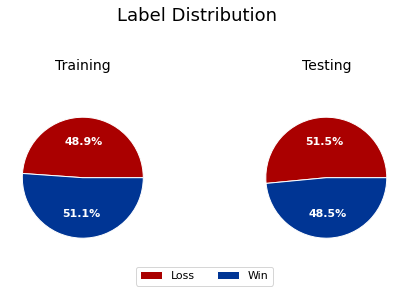

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
y_train_display = y_train.apply(lambda x: 'Win' if x else 'Loss')
ax1 = y_train_display.value_counts().sort_index().plot(
    kind='pie', 
    autopct="%1.1f%%", 
    ylabel='', 
    ax=ax1, 
    colors=palette.binary_colors[::-1], 
    textprops={'color': 'white', 'fontsize': '11', 'weight': 'bold'}
);
ax1.set_title('Training', fontsize=14)

y_test_display = y_test.apply(lambda x: 'Win' if x else 'Loss')
ax2 = y_test_display.value_counts().sort_index().plot(
    kind='pie', 
    autopct="%1.1f%%", 
    ylabel='', 
    ax=ax2,
    colors=palette.binary_colors[::-1], 
    textprops={'color': 'white', 'fontsize': '11', 'weight': 'bold'}
);
ax2.set_title('Testing', fontsize=14)

# fig.tight_layout() 
fig.subplots_adjust(hspace=0.1)   ##  Need to play with this number.
fig.legend(labels=['Loss', 'Win'], loc="lower center", ncol=2)

plt.suptitle('Label Distribution', fontsize=18)
plt.subplots_adjust(top=0.65)
plt.show()

Only slight offset between labels, should not be a significant factor for model performance.

In [50]:
y_train = y_train.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)

In [51]:
print(y_train.shape)
print(y_test.shape)

(2827, 1)
(763, 1)


### Apply data scaling
"*...if test and train datasets are normalized together, then the sample mean and variance used for normalization is a function of the test dataset and thus leakage has occured.*" - **"Using AntiPatterns to avoid MLOps Mistakes" (3.1.4)**

In [52]:
scalers = {}

for col in tqdm(X_train.columns, desc='Scaling features', colour=palette.colors[0]):
    train_scaler = MinMaxScaler()
    s_s = train_scaler.fit_transform(X_train[col].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['train_scaler_' + col] = train_scaler
    X_train[col] = s_s
    
    test_scaler = MinMaxScaler()
    s_s = test_scaler.fit_transform(X_test[col].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['test_scaler_' + col] = test_scaler
    X_test[col] = s_s

Scaling features:   0%|          | 0/210 [00:00<?, ?it/s]

### Transform data back into groups

The data needs to be regrouped for training purposes.

In [53]:
columns = X_train.columns
X_train = X_train.values.reshape(-1, window_size*2, X_train.shape[-1])
X_test = X_test.values.reshape(-1, window_size*2, X_test.shape[-1])

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2827, 24, 210)
(763, 24, 210)
(2827, 1)
(763, 1)


### Define PyTorch Dataset Class

In [55]:
class NFLDataset(Dataset):

    def __init__(self, X, y, columns=[]):
        super(NFLDataset, self).__init__()
        assert len(X) == len(y), 'Length of X and y must be the same'
        self.X = X
        self.y = y
        self.columns = columns

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        window = self.X[idx]
        label = self.y[idx]
        return torch.as_tensor(window).float(), torch.as_tensor(label).float()

    def toPandas(self):
        return pd.DataFrame(self.X.reshape((-1, len(self.columns))), columns=self.columns)

## Time Series Model

### Define a Bidirectional RNN classification architecture

In [56]:
class BidirectionalRNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, rnn_type='LSTM', dropout=0.2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = eval('nn.' + self.rnn_type)(
            input_size=self.input_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers,  
            dropout=self.dropout,
            batch_first=True,
            bidirectional=True
        )

        self.linear = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        out = self.linear(out)
        return out

### Setup datasets for the model

In [57]:
train_dataset = NFLDataset(X_train, y_train, columns=columns)
test_dataset = NFLDataset(X_test, y_test, columns=columns)

### Setup the model and optimizer

In [58]:
INPUT_SIZE = X_train.shape[-1]
OUTPUT_SIZE = 1
NUMBER_OF_LAYERS = 2

# TODO: hpo
HIDDEN_STATE_SIZE = 64
RNN_TYPE = 'LSTM'
DROPOUT = 0.25

model = BidirectionalRNN(
    INPUT_SIZE,
    HIDDEN_STATE_SIZE,
    OUTPUT_SIZE,
    NUMBER_OF_LAYERS,
    RNN_TYPE,
    DROPOUT
)

# TODO: hpo
LEARNING_RATE = 0.001

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train the Model

In [59]:
def plot_seasonal_metrics(model, dataset, ds_type='train', ax=None):
    df = dataset.toPandas()
    seasonal_metrics_arr = []
    
    for ps in df['PredictionSeason'].unique():
        season = int(scalers[ds_type + '_scaler_PredictionSeason'].inverse_transform([[ps]])[0,0])
        mask = df['PredictionSeason'] == ps
        ps_df = df[mask]
        ps_X = ps_df.values.reshape(-1, window_size*2, X_train.shape[-1])
        ps_y = dataset.y[mask[::window_size*2]]
        ps_dataset = NFLDataset(ps_X, ps_y)
        ps_dataloader = DataLoader(ps_dataset, shuffle=False, batch_size=1024)
        
        ps_acc = 0
        
        for samples, labels in ps_dataloader:
            preds =  torch.round(torch.sigmoid(model(samples)))
            labels_np, preds_np = labels.detach().numpy(), preds.detach().numpy()
            ps_acc += balanced_accuracy_score(labels_np, preds_np)
            
        seasonal_metrics_arr.append({
            'Season': season, 
            'BalancedAccuracy (%)': (ps_acc/len(ps_dataloader)) * 100
        })

    seasonal_metrics_df = pd.DataFrame(seasonal_metrics_arr)

    sns.set(rc={'figure.figsize':(12,8)})
    ax = sns.barplot(data=seasonal_metrics_df, x='Season', y='BalancedAccuracy (%)', color=palette.colors[1], ci=None, ax=None)
    # ax = plotting.perc(ax, 100, color='white', height=0.2)
    ax = plotting.change_width(ax, 0.95)
    ax.set_ylim([0, 100])
    ax.set_title('Balanced Accuracy (%) by Season', fontsize=16)
    plt.axhline(y = 70, color = palette.critical_colors[1], linestyle = 'dashed', label = "Competitive Threshold")
    return ax

In [60]:
def train(model, optimizer, train, test, loss_fn, epochs, batch_size):
    loss_fn = getattr(nn.functional, loss_fn)
    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
    fig = plt.figure()
    train_camera = Camera(fig)
    
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)
    model = model.to(device)

    for epoch in trange(epochs, colour=palette.colors[0], desc='Epochs'):
        epoch_train_loss = 0
        epoch_test_loss = 0
        epoch_train_acc = 0
        epoch_test_acc = 0

        for samples, labels in train_dataloader:
            samples = samples.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            raw_preds = model(samples)
            train_loss = loss_fn(raw_preds, labels)
            epoch_train_loss += train_loss.item()
            
            bin_preds = torch.round(torch.sigmoid(raw_preds))
            labels_np, bin_preds_np = labels.detach().numpy(), bin_preds.detach().numpy()
            epoch_train_acc += balanced_accuracy_score(labels_np, bin_preds_np)

            train_loss.backward()
            optimizer.step()

        for samples, labels in test_dataloader:
            samples = samples.to(device)
            labels = labels.to(device)

            raw_preds = model(samples)
            test_loss = loss_fn(raw_preds, labels)
            epoch_test_loss += test_loss.item()
            
            bin_preds = torch.round(torch.sigmoid(raw_preds))
            labels_np, bin_preds_np = labels.detach().numpy(), bin_preds.detach().numpy()
            epoch_test_acc += balanced_accuracy_score(labels_np, bin_preds_np)

        history['train_loss'].append(epoch_train_loss/len(train_dataloader))
        history['train_acc'].append(epoch_train_acc/len(train_dataloader))
        history['test_loss'].append(epoch_test_loss/len(test_dataloader))
        history['test_acc'].append(epoch_test_acc/len(test_dataloader))
        print(f"[{epoch+1}] train loss: {epoch_train_loss/len(train_dataloader)} train acc: {epoch_train_acc/len(train_dataloader)} test loss: {epoch_test_loss/len(test_dataloader)} test acc: {epoch_test_acc/len(test_dataloader)}")
        
        ax = plot_seasonal_metrics(model, train)
        ax.text(0.5, 1.01, f'Epoch: {epoch+1}', transform=ax.transAxes, horizontalalignment='center')
        train_camera.snap()
    
    train_animation = train_camera.animate(interval=600)  
    train_animation.save('training_seasonal_accuracy.gif', writer ='imagemagick')
    plt.close()
    
    return history, train_animation

In [61]:
# TODO: hpo
LOSS_FN = 'binary_cross_entropy_with_logits'
EPOCHS = 3
BATCH_SIZE = 32

history, train_animation = train(model, optimizer, train_dataset, test_dataset, LOSS_FN, EPOCHS, BATCH_SIZE)

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

<Figure size 432x288 with 0 Axes>